
# UmojaHack Algeria: Yassir ETA Prediction Challenge

Established in 2017, Yassir is the leading ride-hailing company in Algeria. It covers all major Algerian cities and is expanding its services to Tunisia, Morocco and France. Besides ride-hailing services, Yassir is making customers’ lives easier by providing diversified services such as goods and food delivery as well as telemedicine.

Ride-hailing apps like Uber and Yassir rely on real-time data and machine learning algorithms to automate their services. 

Accurately predicting the estimated time of arrival (ETA) for Yassir trips will make Yassir’s services more reliable and attractive; this will have a direct and indirect impact on both customers and business partners. The solution would help the company save money and allocate more resources to other parts of the business.

**The objective of this hackathon is to predict the estimated time of arrival at the dropoff point for a single Yassir journey.**

###Importing libraries

In [21]:
import numpy as np #
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns

import xgboost as xgb
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as rmse
from sklearn.decomposition import PCA

from sklearn.cluster import MiniBatchKMeans


plt.rcParams['figure.figsize'] = [20,11]


## 1. DATA

### 1.1. Importing the data

**Data files :**


1.   ***Train.csv*** : contains details for 119,549 trips. Each row contains a start location and end location (reported as latitude and longitude to within approximately 100m) and the travel distance along the fastest route, as well as the target, ‘ETA’

2.   ***Weather.csv*** : includes temperature, rainfall and wind speed for the time period during which the trip data was collected.
3. ***Test.csv*** : contains data necessary to make the submission 



In [2]:
Train=pd.read_csv("/content/Train.csv").set_index('ID')
Train['Timestamp'] = pd.to_datetime(Train['Timestamp'])
Train.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA
ID,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627.0,2784.0
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918.0,576.0
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265.0,526.0
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350.0,3130.0
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613.0,2138.0


In [3]:
Test=pd.read_csv("/content/Test.csv").set_index('ID')
Test['Timestamp'] = pd.to_datetime(Test['Timestamp'])
Test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance
ID,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513


In [4]:
Weather=pd.read_csv("/content/Weather.csv")
Weather['date'] = pd.to_datetime(Weather['date'])
Weather.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


### 1.2. Exploring the data

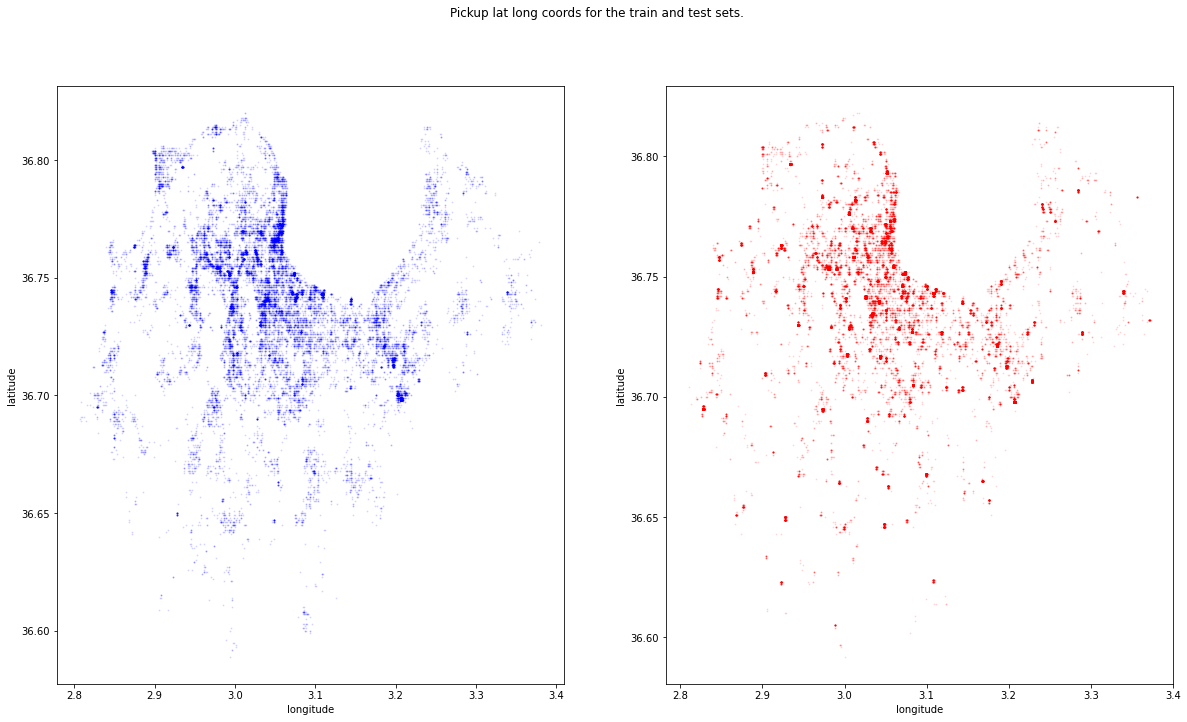

In [24]:
N = 60000
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(Train['Origin_lat'].values[:N],Train['Origin_lon'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter( Test['Destination_lat'].values[:N],Test['Destination_lon'].values[:N],
              color='red', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords for the train and test sets.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_ylabel('latitude')
ax[1].set_xlabel('longitude')

plt.show()

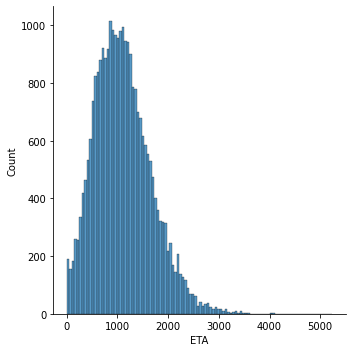

In [23]:
# ETA distribution 
sns.displot(data=Train, x='ETA')

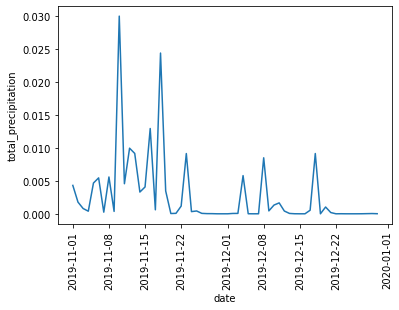

In [14]:
sns.lineplot(data=Weather, y='total_precipitation', x='date')
plt.tick_params(axis='x', rotation=90)

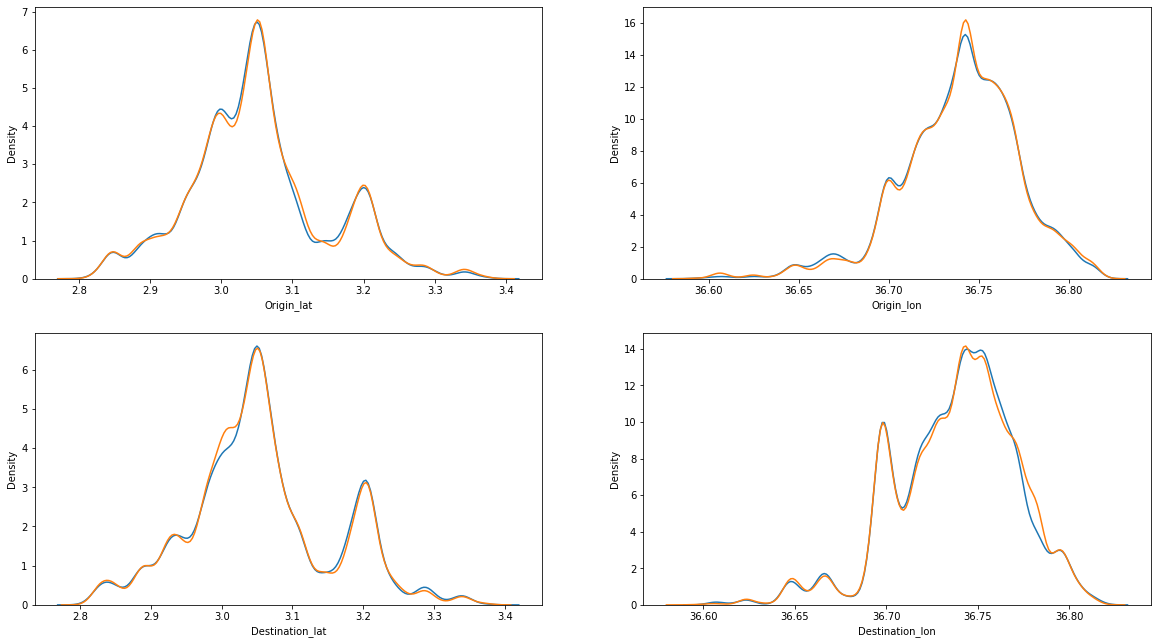

In [37]:
# pickup points distribution 
fig, axes = plt.subplots(2,2)

sns.kdeplot(data= Train, x='Origin_lat', ax= axes[0,0])
sns.kdeplot(data= Test, x='Origin_lat', ax= axes[0,0])

sns.kdeplot(data= Train, x='Origin_lon', ax= axes[0,1])
sns.kdeplot(data= Test, x='Origin_lon', ax= axes[0,1])

sns.kdeplot(data= Train, x='Destination_lat', ax= axes[1,0])
sns.kdeplot(data= Test, x='Destination_lat', ax= axes[1,0])

sns.kdeplot(data= Train, x='Destination_lon', ax= axes[1,1])
sns.kdeplot(data= Test, x='Destination_lon', ax= axes[1,1])



plt.show()

## 2. Adding features

### 2.1. Distance and direction

In [ ]:
!pip install haversine
from haversine import haversine,haversine_vector

In [ ]:
pickup=list(zip(Train["Origin_lat"].values,Train["Origin_lon"].values))

dropoff=list(zip(Train["Destination_lat"].values,Train["Destination_lon"].values))

Train["distance"]=haversine_vector(pickup,dropoff)*1000


pickup=list(zip(Test["Origin_lat"].values,Test["Origin_lon"].values))

dropoff=list(zip(Test["Destination_lat"].values,Test["Destination_lon"].values))

Test["distance"]=haversine_vector(pickup,dropoff)*1000

In [ ]:
Test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,distance
ID,,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,7336.542392
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,5079.900635
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,5913.088797
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,34314.349857
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,3585.865680


In [ ]:
def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

Train["direction"]=bearing_array( Train['Origin_lat'].values,Train['Origin_lon'].values, Train['Destination_lon'].values,Train['Destination_lat'].values)


In [ ]:
Train.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,distance,direction
ID,,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,29101.605590,-38.558627
000RGOAM,2019-12-10 22:37:09+00:00,3.087,36.707,3.081,36.727,3918,576,2318.736654,-38.340067
001QSGIH,2019-11-23 20:36:10+00:00,3.144,36.739,3.088,36.742,7265,526,6235.827046,-38.376165
002ACV6R,2019-12-01 05:43:21+00:00,3.239,36.784,3.054,36.763,23350,3130,20702.801288,-38.467117
0039Y7A8,2019-12-17 20:30:20+00:00,2.912,36.707,3.207,36.698,36613,2138,32817.767383,-38.175782


In [ ]:
Test["direction"]=bearing_array(Test['Origin_lat'].values,Test['Origin_lon'].values, Test['Destination_lat'].values, Test['Destination_lon'].values)

In [ ]:
Test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,distance,direction
ID,,,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,7336.542392,92.604365
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,5079.900635,-23.168662
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,5913.088797,118.041018
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,34314.349857,-7.435895
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,3585.865680,172.883570


### 2.2. LOG transformation

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


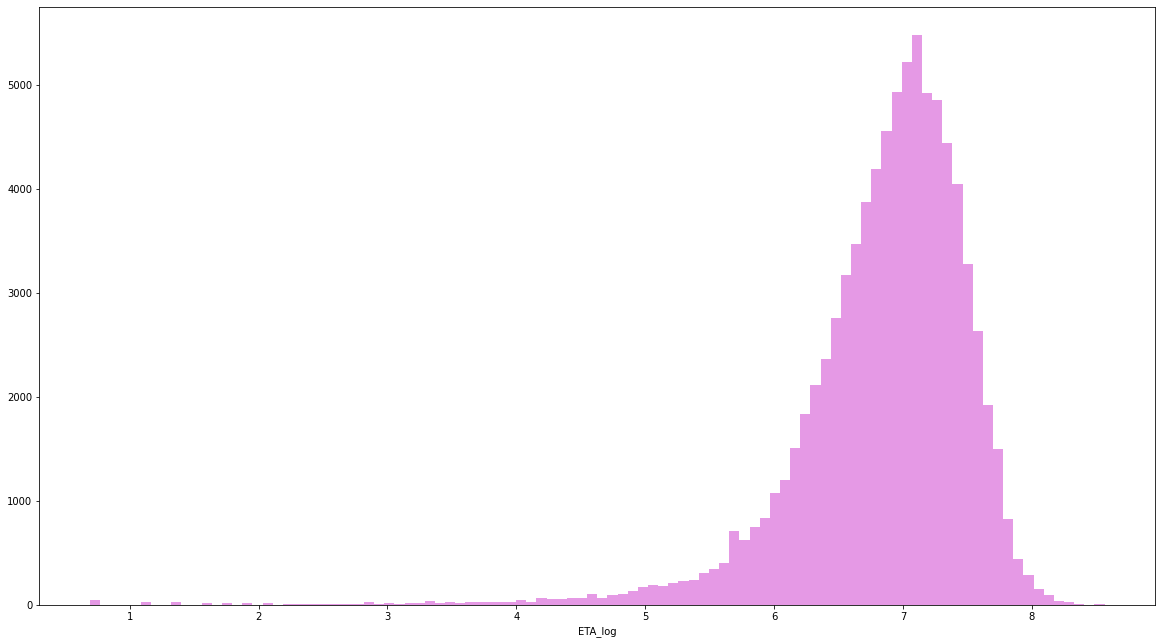

In [ ]:
Train["ETA_log"]=np.log(Train["ETA"].values+1)
sns.distplot(Train["ETA_log"], hist=True, kde=False,bins=100,color="m")
plt.show()

### 2.3. Combining Weather and trips data

In [ ]:
Weather.head()

,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
0,2019-11-01,290.630524,296.434662,294.125061,101853.617188,292.503998,100806.351562,0.004297,3.561323,0.941695
1,2019-11-02,289.135284,298.432404,295.551666,101225.164062,293.337921,100187.250000,0.001767,5.318593,3.258237
2,2019-11-03,287.667694,296.612122,295.182831,100806.617188,293.674316,99771.414062,0.000797,8.447649,3.172982
3,2019-11-04,287.634644,297.173737,294.368134,101240.929688,292.376221,100200.843750,0.000393,5.991428,2.236700
4,2019-11-05,286.413788,294.284851,292.496979,101131.750000,289.143066,100088.500000,0.004658,6.962730,2.655364


In [ ]:
Train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 83924 entries, 000FLWA8 to ZZZY11ZN
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp        83924 non-null  datetime64[ns, UTC]
 1   Origin_lat       83924 non-null  float64            
 2   Origin_lon       83924 non-null  float64            
 3   Destination_lat  83924 non-null  float64            
 4   Destination_lon  83924 non-null  float64            
 5   Trip_distance    83924 non-null  int64              
 6   ETA              83924 non-null  int64              
 7   distance         83924 non-null  float64            
 8   direction        83924 non-null  float64            
 9   ETA_log          83924 non-null  float64            
dtypes: datetime64[ns, UTC](1), float64(7), int64(2)
memory usage: 7.0+ MB


In [ ]:
Train["date"]=Train["Timestamp"].dt.date
Train["date"]=pd.to_datetime(Train["date"])
merge=pd.merge(Train,Weather, how='inner', on='date',right_index=True)
merge.head(10)

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,distance,direction,ETA_log,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
ID,,,,,,,,,,,,,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,29101.605590,-38.558627,7.932003,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
00GNWV6A,2019-12-04 22:00:44+00:00,3.046,36.738,3.147,36.721,12739,1029,11388.220257,-38.296827,6.937314,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
00XPS8UK,2019-12-04 23:49:23+00:00,2.869,36.731,3.070,36.744,24341,1202,22396.783295,-38.215244,7.092574,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
01B8ZCXU,2019-12-04 23:16:15+00:00,3.004,36.797,3.055,36.773,11520,1252,6265.910471,-38.322628,7.133296,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
01NOTKQS,2019-12-04 20:48:01+00:00,2.906,36.710,3.049,36.750,19087,1728,16509.635798,-38.231002,7.455298,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
02269DJO,2019-12-04 05:53:15+00:00,3.168,36.724,3.091,36.738,11330,929,8701.976521,-38.382277,6.835185,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
02WUD0FP,2019-12-04 05:17:32+00:00,3.034,36.746,3.207,36.698,21495,1242,19961.350708,-38.277324,7.125283,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
036ANI1H,2019-12-04 21:43:37+00:00,3.100,36.619,3.091,36.672,7671,781,5969.227850,-38.337600,6.661855,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786
03KO58Z8,2019-12-04 00:53:39+00:00,3.284,36.786,2.934,36.797,51830,3051,38937.437631,-38.543724,8.023552,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786


In [ ]:
Test["date"]=Test["Timestamp"].dt.date
Test["date"]=pd.to_datetime(Test["date"])
Test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 35625 entries, 000V4BQX to ZZZYTWJA
Data columns (total 9 columns):
 #   Column           Non-Null Count  Dtype              
---  ------           --------------  -----              
 0   Timestamp        35625 non-null  datetime64[ns, UTC]
 1   Origin_lat       35625 non-null  float64            
 2   Origin_lon       35625 non-null  float64            
 3   Destination_lat  35625 non-null  float64            
 4   Destination_lon  35625 non-null  float64            
 5   Trip_distance    35625 non-null  int64              
 6   distance         35625 non-null  float64            
 7   direction        35625 non-null  float64            
 8   date             35625 non-null  datetime64[ns]     
dtypes: datetime64[ns, UTC](1), datetime64[ns](1), float64(6), int64(1)
memory usage: 2.7+ MB


In [ ]:
Test=pd.merge(Test,Weather, how='left', on='date',right_index=True)
Test.head(10)

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,distance,direction,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m
ID,,,,,,,,,,,,,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,7336.542392,92.604365,2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,5079.900635,-23.168662,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,5913.088797,118.041018,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,34314.349857,-7.435895,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,3585.865680,172.883570,2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00A3ZHHB,2019-12-22 21:44:37+00:00,3.101,36.737,3.083,36.738,3243,2004.588844,176.824763,2019-12-22,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00BRKED8,2019-12-21 20:06:04+00:00,3.013,36.762,3.082,36.727,9878,8600.590855,-26.862609,2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00F6T3BP,2019-12-31 22:38:07+00:00,2.995,36.737,3.047,36.783,9048,7715.145995,41.455720,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
00HN6E8I,2019-12-23 20:02:21+00:00,3.208,36.698,3.010,36.770,24257,23423.065109,160.042018,2019-12-23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### 2.4. Dummy variables

In [ ]:
merge['Month'] = merge['Timestamp'].dt.month
merge=pd.get_dummies(merge, columns=['Month'])

merge['Hour'] = merge['Timestamp'].dt.hour
merge=pd.get_dummies(merge, columns=['Hour'])

merge['Day'] = merge['Timestamp'].dt.day
merge=pd.get_dummies(merge, columns=['Day'])




merge.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,distance,direction,ETA_log,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,Month_11,Month_12,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_20,Hour_21,Hour_22,Hour_23,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,29101.605590,-38.558627,7.932003,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00GNWV6A,2019-12-04 22:00:44+00:00,3.046,36.738,3.147,36.721,12739,1029,11388.220257,-38.296827,6.937314,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
00XPS8UK,2019-12-04 23:49:23+00:00,2.869,36.731,3.070,36.744,24341,1202,22396.783295,-38.215244,7.092574,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
01B8ZCXU,2019-12-04 23:16:15+00:00,3.004,36.797,3.055,36.773,11520,1252,6265.910471,-38.322628,7.133296,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
01NOTKQS,2019-12-04 20:48:01+00:00,2.906,36.710,3.049,36.750,19087,1728,16509.635798,-38.231002,7.455298,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Test['Month'] = Test['Timestamp'].dt.month
Test=pd.get_dummies(Test, columns=['Month'])

Test['Hour'] = Test['Timestamp'].dt.hour
Test=pd.get_dummies(Test, columns=['Hour'])

Test['Day'] = Test['Timestamp'].dt.day
Test=pd.get_dummies(Test, columns=['Day'])




Test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,distance,direction,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,Month_12,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_20,Hour_21,Hour_22,Hour_23,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,7336.542392,92.604365,2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,5079.900635,-23.168662,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,5913.088797,118.041018,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,34314.349857,-7.435895,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,3585.865680,172.883570,2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
Test.shape

(35625, 41)

### 2.5. Kmeans Clustering

In [ ]:
coords = np.vstack((Train[['Origin_lon', 'Origin_lat']].values,
                    Train[['Destination_lon', 'Destination_lat']].values))

In [ ]:
sample_ind = np.random.permutation(len(coords))
kmeans = MiniBatchKMeans(n_clusters=57, batch_size=1000).fit(coords[sample_ind])

In [ ]:
#merge=Train

In [ ]:
merge['pickup_cluster'] = kmeans.predict(merge[['Origin_lon', 'Origin_lat']])
merge['dropoff_cluster'] = kmeans.predict(merge[['Destination_lon', 'Destination_lat']])
Test['pickup_cluster'] = kmeans.predict(Test[['Origin_lon', 'Origin_lat']])
Test['dropoff_cluster'] = kmeans.predict(Test[['Destination_lon', 'Destination_lat']])

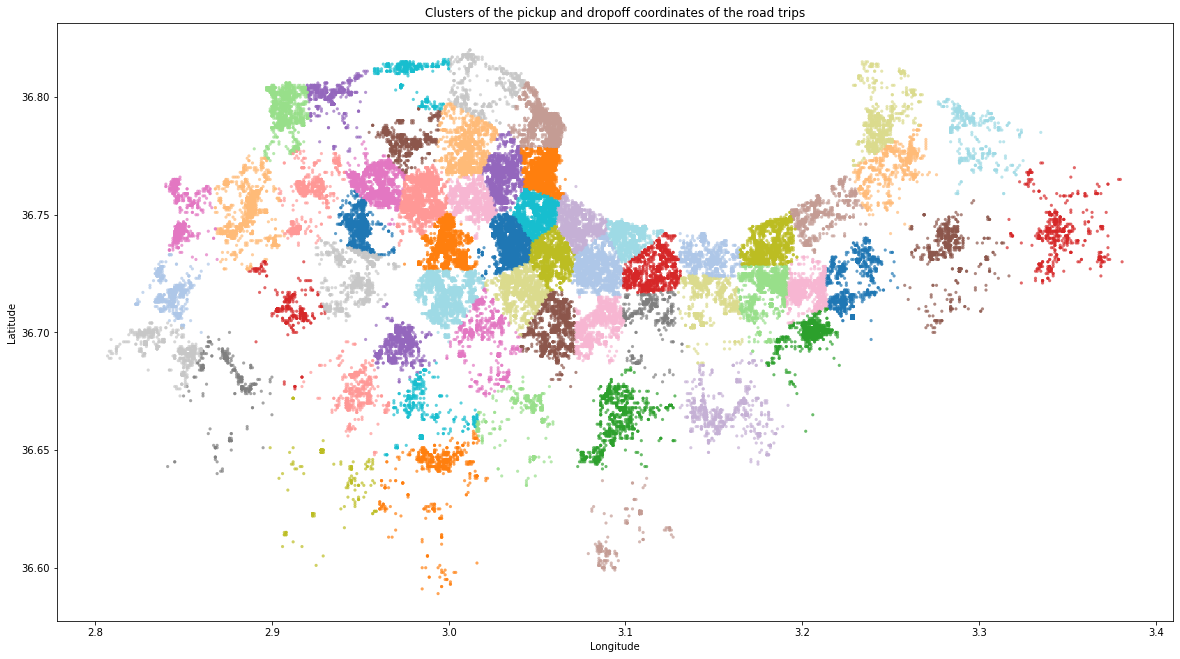

In [ ]:
fig, ax = plt.subplots(ncols=1, nrows=1)
ax.scatter(merge.Origin_lat.values, merge.Origin_lon.values, s=10, lw=0,
           c=merge.pickup_cluster.values, cmap='tab20', alpha=0.7)
ax.set_title("Clusters of the pickup and dropoff coordinates of the road trips")
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.savefig('map.png')
plt.show()


In [ ]:
Test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,distance,direction,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,Month_12,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_20,Hour_21,Hour_22,Hour_23,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,pickup_cluster,dropoff_cluster
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,7336.542392,92.604365,2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,23,21
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,5079.900635,-23.168662,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,24,26
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,5913.088797,118.041018,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,48,37
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,34314.349857,-7.435895,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,10,12
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,3585.865680,172.883570,2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,43,43


### 2.6. Manhatten distance

In [ ]:
def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

In [ ]:
#merge=Train

In [ ]:
merge['distance_dummy_manhattan'] =1000*  dummy_manhattan_distance( merge['Origin_lat'].values,merge['Origin_lon'].values, merge['Destination_lat'].values ,merge['Destination_lon'].values)
Test['distance_dummy_manhattan'] =1000*  dummy_manhattan_distance(Test['Origin_lat'].values,Test['Origin_lon'].values, Test['Destination_lat'].values, Test['Destination_lon'].values)

In [ ]:
merge.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,ETA,distance,direction,ETA_log,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,Month_11,Month_12,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_20,Hour_21,Hour_22,Hour_23,Day_1,Day_2,Day_3,Day_4,Day_5,Day_6,Day_7,Day_8,Day_9,Day_10,Day_11,Day_12,Day_13,Day_14,Day_15,Day_16,Day_17,Day_18,Day_19,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,pickup_cluster,dropoff_cluster,distance_dummy_manhattan
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000FLWA8,2019-12-04 20:01:50+00:00,3.258,36.777,3.003,36.718,39627,2784,29101.605590,-38.558627,7.932003,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,9,56,34904.603524
00GNWV6A,2019-12-04 22:00:44+00:00,3.046,36.738,3.147,36.721,12739,1029,11388.220257,-38.296827,6.937314,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,49,13118.330699
00XPS8UK,2019-12-04 23:49:23+00:00,2.869,36.731,3.070,36.744,24341,1202,22396.783295,-38.215244,7.092574,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,34,26,23793.902447
01B8ZCXU,2019-12-04 23:16:15+00:00,3.004,36.797,3.055,36.773,11520,1252,6265.910471,-38.322628,7.133296,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,42,7,8335.952410
01NOTKQS,2019-12-04 20:48:01+00:00,2.906,36.710,3.049,36.750,19087,1728,16509.635798,-38.231002,7.455298,2019-12-04,283.047546,288.319153,286.984436,100523.0625,286.00177,99474.21875,0.00578,1.914582,2.437786,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,18,51,20342.951947


### 2.7. PCA

In [ ]:
coords = np.vstack((merge[['Origin_lon', 'Origin_lat']].values,
                    merge[['Destination_lon', 'Destination_lat']].values,
                    Test[['Origin_lon', 'Origin_lat']].values,
                    Test[['Destination_lon', 'Destination_lat']].values))

pca = PCA().fit(coords)
merge['pickup_pca0'] = pca.transform(merge[['Origin_lon', 'Origin_lat']])[:, 0]
merge['pickup_pca1'] = pca.transform(merge[['Origin_lon', 'Origin_lat']])[:, 1]
merge['dropoff_pca0'] = pca.transform(merge[['Destination_lon', 'Destination_lat']])[:, 0]
merge['dropoff_pca1'] = pca.transform(merge[['Destination_lon', 'Destination_lat']])[:, 1]
Test['pickup_pca0'] = pca.transform(Test[['Origin_lon', 'Origin_lat']])[:, 0]
Test['pickup_pca1'] = pca.transform(Test[['Origin_lon', 'Origin_lat']])[:, 1]
Test['dropoff_pca0'] = pca.transform(Test[['Destination_lon', 'Destination_lat']])[:, 0]
Test['dropoff_pca1'] = pca.transform(Test[['Destination_lon', 'Destination_lat']])[:, 1]

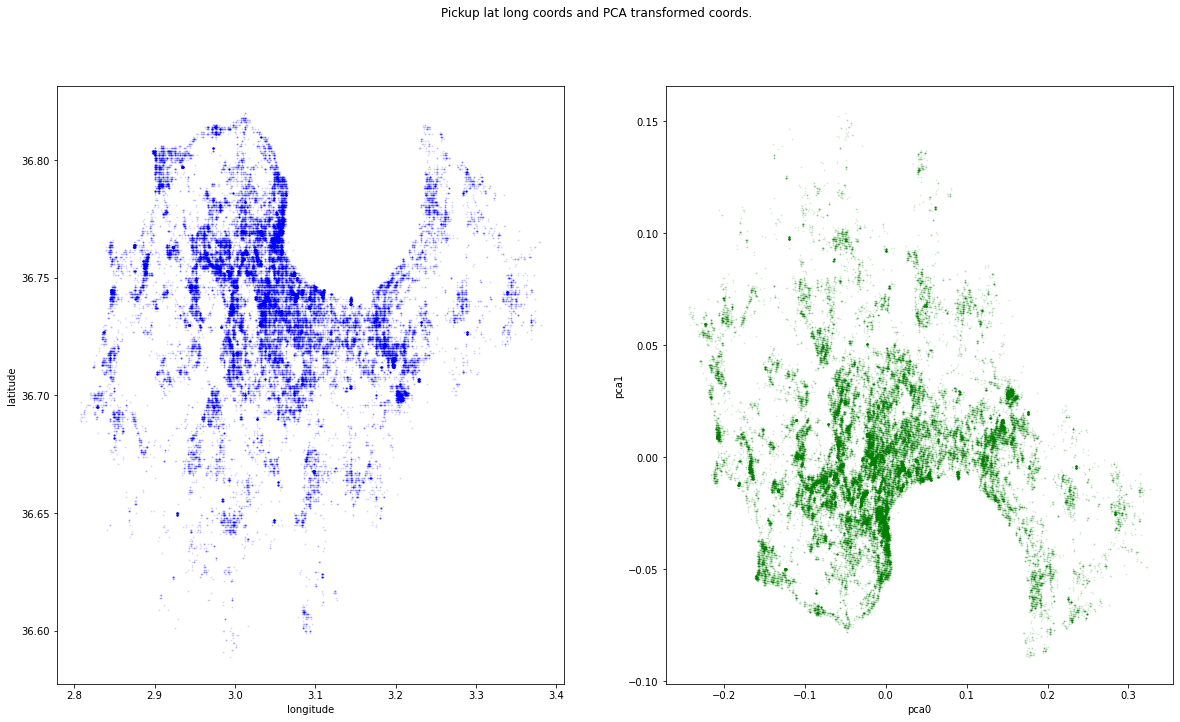

In [ ]:
N = 100000
fig, ax = plt.subplots(ncols=2)
ax[0].scatter(merge['Origin_lat'].values[:N], merge['Origin_lon'].values[:N],
              color='blue', s=1, alpha=0.1)
ax[1].scatter(merge['pickup_pca0'].values[:N], merge['pickup_pca1'].values[:N],
              color='green', s=1, alpha=0.1)
fig.suptitle('Pickup lat long coords and PCA transformed coords.')
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].set_xlabel('pca0')
ax[1].set_ylabel('pca1')

plt.show()

##Model

In [ ]:
Test.columns

Index(['Timestamp', 'Origin_lat', 'Origin_lon', 'Destination_lat',
       'Destination_lon', 'Trip_distance', 'distance', 'direction', 'date',
       'dewpoint_2m_temperature', 'maximum_2m_air_temperature',
       'mean_2m_air_temperature', 'mean_sea_level_pressure',
       'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation',
       'u_component_of_wind_10m', 'v_component_of_wind_10m', 'Month_12',
       'Hour_0', 'Hour_1', 'Hour_2', 'Hour_3', 'Hour_4', 'Hour_5', 'Hour_20',
       'Hour_21', 'Hour_22', 'Hour_23', 'Day_20', 'Day_21', 'Day_22', 'Day_23',
       'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30',
       'Day_31', 'pickup_cluster', 'dropoff_cluster',
       'distance_dummy_manhattan', 'pickup_pca0', 'pickup_pca1',
       'dropoff_pca0', 'dropoff_pca1'],
      dtype='object')

In [ ]:
X=merge.loc[:,~merge.columns.duplicated()]
#X['Day_31']=0
X=X[['Trip_distance', 'distance', 'direction', 
       'dewpoint_2m_temperature', 'maximum_2m_air_temperature',
       'mean_2m_air_temperature', 'mean_sea_level_pressure',
       'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation',
       'u_component_of_wind_10m', 'v_component_of_wind_10m', 'Month_12',
       'Day_20', 'Day_21', 'Day_22', 'Day_23',
       'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30',
        'pickup_cluster', 'dropoff_cluster',
       'distance_dummy_manhattan', 'pickup_pca0', 'pickup_pca1',
        'dropoff_pca0', 'dropoff_pca1']]
Y=merge["ETA_log"]
X.shape

(83924, 31)

In [ ]:
X_train,X_test,y_train,y_test=train_test_split(X,Y,train_size=0.2,random_state=4)

dtrain = xgb.DMatrix(X_train, label=y_train)
dvalid = xgb.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

In [ ]:
#for param in [100]:#[i/10. for i in range(7,11)]:
xgb_pars = {'min_child_weight': 2,#2= 1-6 
              'learning_rate' :0.01,#7
              'n_estimators':1000,#6
              'eta': 0.5, 
              'gamma ':0.0,#3= i/10 i=0:5
              'colsample_bytree': 0.9, #4= 0.5-0.9
              'max_depth': 3, #1 = 3-10
              'subsample': 0.9, #4 0.5-0.9
              'reg_alpha':0, #5= [1e-5, 1e-2, 0.1, 1, 100]
              'lambda': 1., 
              'nthread': -1,
              'booster' : 'gbtree', 
              'silent':0,
              'eval_metric': 'rmse', 
              'alpha':1,
              'objective': 'reg:linear'}

model = xgb.train(xgb_pars, dtrain, 10000, watchlist, early_stopping_rounds=100,
        maximize=False, verbose_eval=1000)
  
print('for param=','Modeling RMSE %.5f' % model.best_score)

[19:16:40] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:6.31134	valid-rmse:6.32022
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 100 rounds.
[1000]	train-rmse:0.188544	valid-rmse:0.196302
[2000]	train-rmse:0.17457	valid-rmse:0.188234
[3000]	train-rmse:0.165201	valid-rmse:0.184057
[4000]	train-rmse:0.158555	valid-rmse:0.181831
[5000]	train-rmse:0.153149	valid-rmse:0.17994
[6000]	train-rmse:0.148755	valid-rmse:0.178711
[7000]	train-rmse:0.144768	valid-rmse:0.177683
[8000]	train-rmse:0.141064	valid-rmse:0.176729
[9000]	train-rmse:0.137711	valid-rmse:0.175977
[9999]	train-rmse:0.134659	valid-rmse:0.175327
for param= Modeling RMSE 0.17533


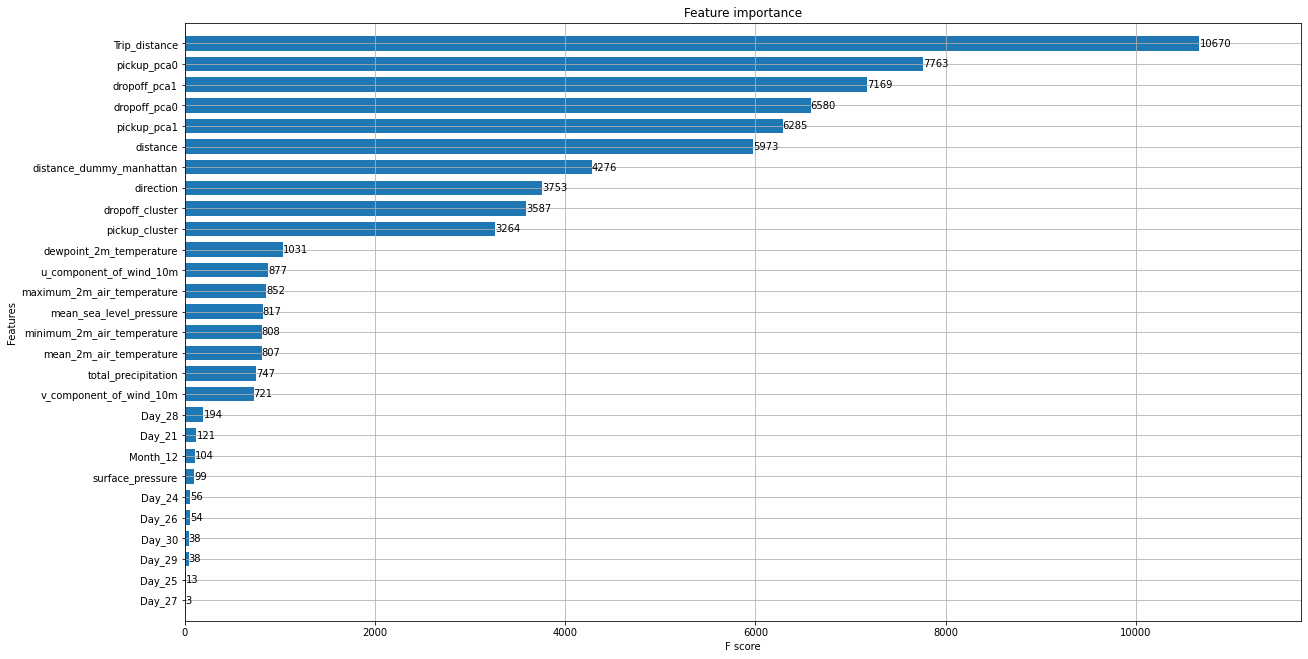

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [ ]:
sub=Test[['Trip_distance', 'distance', 'direction', 
       'dewpoint_2m_temperature', 'maximum_2m_air_temperature',
       'mean_2m_air_temperature', 'mean_sea_level_pressure',
       'minimum_2m_air_temperature', 'surface_pressure', 'total_precipitation',
       'u_component_of_wind_10m', 'v_component_of_wind_10m', 'Month_12',
       'Day_20', 'Day_21', 'Day_22', 'Day_23',
       'Day_24', 'Day_25', 'Day_26', 'Day_27', 'Day_28', 'Day_29', 'Day_30',
        'pickup_cluster', 'dropoff_cluster',
       'distance_dummy_manhattan', 'pickup_pca0', 'pickup_pca1',
        'dropoff_pca0', 'dropoff_pca1']]
X_pred=xgb.DMatrix(sub)

pred = model.predict(X_pred)
pred=np.exp(pred)-1
Test["ETA"]=pred
Test.head()

,Timestamp,Origin_lat,Origin_lon,Destination_lat,Destination_lon,Trip_distance,distance,direction,date,dewpoint_2m_temperature,maximum_2m_air_temperature,mean_2m_air_temperature,mean_sea_level_pressure,minimum_2m_air_temperature,surface_pressure,total_precipitation,u_component_of_wind_10m,v_component_of_wind_10m,Month_12,Hour_0,Hour_1,Hour_2,Hour_3,Hour_4,Hour_5,Hour_20,Hour_21,Hour_22,Hour_23,Day_20,Day_21,Day_22,Day_23,Day_24,Day_25,Day_26,Day_27,Day_28,Day_29,Day_30,Day_31,pickup_cluster,dropoff_cluster,distance_dummy_manhattan,pickup_pca0,pickup_pca1,dropoff_pca0,dropoff_pca1,ETA
ID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
000V4BQX,2019-12-21 05:52:37+00:00,2.981,36.688,2.978,36.754,17549,7336.542392,92.604365,2019-12-21,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,23,21,7662.519243,-0.069725,0.055732,-0.077368,-0.009892,1283.629395
003WBC5J,2019-12-25 21:38:53+00:00,3.032,36.769,3.074,36.751,7532,5079.900635,-23.168662,2019-12-25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,24,26,6668.893785,-0.024559,-0.028660,0.018605,-0.013664,772.403687
004O4X3A,2019-12-29 21:30:29+00:00,3.035,36.711,3.010,36.758,10194,5913.088797,118.041018,2019-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,48,37,7998.704390,-0.017480,0.028985,-0.045730,-0.016137,995.682556
006CEI5B,2019-12-31 22:51:57+00:00,2.902,36.738,3.208,36.698,32768,34314.349857,-7.435895,2019-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,10,12,38467.740722,-0.152052,0.011423,0.156006,0.029762,1880.439697
009G0M2T,2019-12-28 21:47:22+00:00,2.860,36.692,2.828,36.696,4513,3585.865680,172.883570,2019-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,43,43,4002.463357,-0.190706,0.060269,-0.222908,0.058533,595.023010


In [ ]:
Test[["ETA"]].to_csv('sub18.csv')